# Import Required Libraries

In [48]:
import time
import folium
import itertools
import numpy as np             
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
from datetime import datetime
from tqdm import tqdm_notebook

import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import plotly.express as px
from matplotlib import pyplot as plt


import sklearn
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn_pandas import DataFrameMapper
from sklearn.metrics.pairwise import euclidean_distances

# plt.style.use("fivethirtyeight")
# from warnings import filterwarnings
# filterwarnings("ignore")

# Import Dataset

#### Features Detail:

A. Days consist of 7 values: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday

B. Accident type consist of 7 values: 
 1. T = Kecelakaan Tunggal
 2. TK = Kecelakaan antar Kendaraan
 3. TM = Tabrak Manusia
 4. TL = Tabrak Lari
 5. OC = Out of Control (Jatuh sendiri/kesalahan sendiri)
 6. TB = Tabrakan beruntun
 7. LL = Lain-lain (tabrak pagar/rumah/dsb)
 
 
C. Vehicle Type consist of 14 values:
 1. R2 = Motor
 2. R3 = Motor Viar
 3. R4 = Mobil Penumpang
 4. R6 = Truk
 5. R8 = Truk
 6. R10 = Truk 
 7. R12 = Truk
 8. R14 = Truk
 9. M = Microlet
 10. B = Bus
 11. B1 = Becak
 12. B2 = Becak Motor
 13. Tx = Taxi
 14. Rro = Sepeda

In [49]:
df = pd.read_csv("data.csv")
df.drop(["no", "date", "suspect_age", "victim_age", "MD", "LB", "LR", "material_loss"], axis="columns", inplace=True)
df.columns = ["day", "time", "address", "district", "accident_types", "suspect_vehicle", "victim_vehicle"]
print(df.shape)
df.head()

(3558, 7)


,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle
0,Thursday,21:30,Insinyur Sutami,Tamalanrea,T,R2,-
1,Sunday,9:30,Tol reformasi,Tamalanrea,TK,R6,R4
2,Sunday,16:30,Perintis Kemerdekaan,Biringkanaya,TK,R2,R4
3,Friday,2:30,Jenderal Sudirman,Ujung Pandang,T,R2,-
4,Sunday,17:30,Tanjung Alang,Mamajang,TM,R2,-


In [50]:
days = df["day"].unique() 
print("Total days: {} \n{}\n".format(len(days), days))

accident_type = df["accident_types"].unique()
print("Total accident types: {} \n{}\n".format(len(accident_type), accident_type))

suspect_vehicle = df["suspect_vehicle"].unique()
print("Total vehicle types (suspect): {} \n{}\n".format(len(suspect_vehicle), suspect_vehicle))

victim_vehicle = df["victim_vehicle"].unique()
print("Total vehicle types (victim): {} \n{}\n".format(len(victim_vehicle), victim_vehicle))

Total days: 7 
['Thursday' 'Sunday' 'Friday' 'Monday' 'Saturday' 'Tuesday' 'Wednesday']

Total accident types: 7 
['T' 'TK' 'TM' 'TL' 'OC' 'TB' 'LL']

Total vehicle types (suspect): 14 
['R2' 'R6' 'R4' 'M' 'B2' 'B' 'R3' 'B1' 'R10' 'Rro' 'T' 'R14' 'R12' 'R8']

Total vehicle types (victim): 13 
['-' 'R4' 'R2' 'Rro' 'B1' 'R6' 'B2' 'B' 'R3' 'R10' 'M' 'T' 'R14']



# Data Preprocessing

In [51]:
df["address"] = df["address"].map(lambda x: str(x).strip().lower())
df["district"] = df["district"].map(lambda x: str(x).strip().lower())
df.head()

,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle
0,Thursday,21:30,insinyur sutami,tamalanrea,T,R2,-
1,Sunday,9:30,tol reformasi,tamalanrea,TK,R6,R4
2,Sunday,16:30,perintis kemerdekaan,biringkanaya,TK,R2,R4
3,Friday,2:30,jenderal sudirman,ujung pandang,T,R2,-
4,Sunday,17:30,tanjung alang,mamajang,TM,R2,-


In [52]:
df[df.isna().any(axis=1)]

,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle


In [53]:
df = df.replace('NaN', np.nan)
df = df.dropna()
print(df.shape)

(3558, 7)


## Vehicle types preprocessing

we will narrow down vehicle types whose wheels are more than 6 will be declared as trucks (TR).Therefore, our vehicle types will become 10 types instead of 14. Also with Mobil Roda 4 and Taxi will be narrowed to R4 (Mobil Roda 4) :
 1. R2 = Motor
 2. R3 = Motor Viar
 3. R4 = Mobil Roda 4 / Taxi
 4. TR = Truk
 5. M = Microlet
 6. B = Bus
 7. B1 = Becak
 8. B2 = Becak Motor
 9. Rro = Sepeda

In [54]:
exception = ["TR","Rro", "NOV"]

df["suspect_vehicle"] = df.suspect_vehicle.apply(lambda x: "TR" if(len(x)>1 and x not in exception and int(x[1:])>=6) else x)
df["victim_vehicle"] = df.victim_vehicle.apply(lambda x: "TR" if(len(x)>1 and x not in exception and int(x[1:])>=6) else x)

df["suspect_vehicle"] = df["suspect_vehicle"].replace("T", "R4").replace("-", "NOV")
df["victim_vehicle"] = df["victim_vehicle"].replace("T", "R4").replace("-", "NOV")

print(df.shape)
df.head(10)

(3558, 7)


,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle
0,Thursday,21:30,insinyur sutami,tamalanrea,T,R2,NOV
1,Sunday,9:30,tol reformasi,tamalanrea,TK,TR,R4
2,Sunday,16:30,perintis kemerdekaan,biringkanaya,TK,R2,R4
3,Friday,2:30,jenderal sudirman,ujung pandang,T,R2,NOV
4,Sunday,17:30,tanjung alang,mamajang,TM,R2,NOV
5,Monday,0:15,urip sumuharjo,panakkukang,T,R4,NOV
6,Saturday,19:00,lamadukelleng,ujung pandang,TL,R2,R2
7,Friday,17:30,pettarani,panakkukang,TK,R4,R2
8,Monday,0:30,sungai saddang baru,makassar,TL,R2,R2
9,Sunday,13:00,gagak,mariso,OC,R2,NOV


## Change time from hours to categorical time

In [55]:
df["time"] = pd.to_datetime(df['time'], format = '%H:%M').dt.hour

In [56]:
def conv_time(hour):
    if 5<=hour<=11:
        return "Morning"
    elif 12<=hour<=17:
        return "Afternoon"
    elif 18<=hour<=22:
        return "Evening"
    else:
        return "Night"
    
df["time"] = df["time"].map(lambda x: conv_time(x))
df.head()

,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle
0,Thursday,Evening,insinyur sutami,tamalanrea,T,R2,NOV
1,Sunday,Morning,tol reformasi,tamalanrea,TK,TR,R4
2,Sunday,Afternoon,perintis kemerdekaan,biringkanaya,TK,R2,R4
3,Friday,Night,jenderal sudirman,ujung pandang,T,R2,NOV
4,Sunday,Afternoon,tanjung alang,mamajang,TM,R2,NOV


## Address Preprocessing

In [57]:
location_df = df[["address", "district"]].copy()
location_df = location_df.drop_duplicates(subset=['address', 'district'])
location_df.reset_index(drop=True, inplace=True)
print(location_df.shape)
location_df.head()

(533, 2)


,address,district
0,insinyur sutami,tamalanrea
1,tol reformasi,tamalanrea
2,perintis kemerdekaan,biringkanaya
3,jenderal sudirman,ujung pandang
4,tanjung alang,mamajang


In [58]:
# we'll add lat and long column into location_df dataframe
location_df['lat'] = ''
location_df['long'] = ''

start_time = datetime.now().strftime("%H:%M:%S")

locator = Nominatim(user_agent="my_app4")
count = 0
for i in tqdm_notebook(range(len(location_df))):
    try:
        address = "jalan "+ (location_df["address"][i]+', '+ location_df["district"][i]).strip()
        location = locator.geocode(address, timeout=8)
        
        if location != None:
            location_df['lat'][i] = location.latitude
            location_df['long'][i] = location.longitude
            
        else:
            print(f"[{count}]. {address}")
            location_df['lat'][i] = np.nan
            location_df['long'][i] = np.nan 
        count += 1
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(address, e.message))
        
print("start:", start_time)
print("finish: ", datetime.now().strftime("%H:%M:%S"))
location_df.head()

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/533 [00:00<?, ?it/s]

start: 13:43:40
finish:  13:48:23


,address,district,lat,long
0,insinyur sutami,tamalanrea,-5.081195,119.500028
1,tol reformasi,tamalanrea,-5.11007,119.443122
2,perintis kemerdekaan,biringkanaya,-5.075747,119.522922
3,jenderal sudirman,ujung pandang,-5.133096,119.413658
4,tanjung alang,mamajang,-5.17357,119.408549


In [59]:
location_merged = df.merge(location_df, how='left', left_on=['address', 'district'], right_on=['address', 'district'])
location_merged = location_merged.dropna()
print(location_merged.shape)
location_merged.head()

(3558, 9)


,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle,lat,long
0,Thursday,Evening,insinyur sutami,tamalanrea,T,R2,NOV,-5.081195,119.500028
1,Sunday,Morning,tol reformasi,tamalanrea,TK,TR,R4,-5.11007,119.443122
2,Sunday,Afternoon,perintis kemerdekaan,biringkanaya,TK,R2,R4,-5.075747,119.522922
3,Friday,Night,jenderal sudirman,ujung pandang,T,R2,NOV,-5.133096,119.413658
4,Sunday,Afternoon,tanjung alang,mamajang,TM,R2,NOV,-5.17357,119.408549


In [60]:
location_merged.to_csv("data_with_coordinates_KMeans.csv", index=False)

# Features Selection

In [61]:
location_df = pd.read_csv("data_with_coordinates_KMeans.csv")
print(location_df.shape)
location_df.head()

(3558, 9)


,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle,lat,long
0,Thursday,Evening,insinyur sutami,tamalanrea,T,R2,NOV,-5.081195,119.500028
1,Sunday,Morning,tol reformasi,tamalanrea,TK,TR,R4,-5.110070,119.443122
2,Sunday,Afternoon,perintis kemerdekaan,biringkanaya,TK,R2,R4,-5.075747,119.522922
3,Friday,Night,jenderal sudirman,ujung pandang,T,R2,NOV,-5.133096,119.413658
4,Sunday,Afternoon,tanjung alang,mamajang,TM,R2,NOV,-5.173570,119.408549


In [62]:
features_df = location_df[["day", "time", "accident_types", "suspect_vehicle", "victim_vehicle"]].copy()
features_df.head()

,day,time,accident_types,suspect_vehicle,victim_vehicle
0,Thursday,Evening,T,R2,NOV
1,Sunday,Morning,TK,TR,R4
2,Sunday,Afternoon,TK,R2,R4
3,Friday,Night,T,R2,NOV
4,Sunday,Afternoon,TM,R2,NOV


# Features Encoding

In [63]:
label_features = features_df.copy()

d_label = LabelBinarizer()
day_label = d_label.fit_transform(label_features["day"])
day_mapping = [label for index, label in enumerate(d_label.classes_)]

t_label = LabelBinarizer()
time_label = t_label.fit_transform(label_features["time"])
time_mapping = [label for index, label in enumerate(t_label.classes_)]

types_label = LabelBinarizer()
accident_label = types_label.fit_transform(label_features["accident_types"])
accident_mapping = [label for index, label in enumerate(types_label.classes_)]

victim_label = LabelBinarizer()
victim_vehicle_label = victim_label.fit_transform(label_features["victim_vehicle"])
victim_mapping = [label for index, label in enumerate(victim_label.classes_)]

suspect_label = LabelBinarizer()
suspect_vehicle_label = suspect_label.fit_transform(label_features["suspect_vehicle"])
suspect_mapping = [label for index, label in enumerate(suspect_label.classes_)]
    
label = day_mapping + time_mapping +accident_mapping + suspect_mapping + victim_mapping
unique_label = list(dict.fromkeys(label))
unique_label.remove("NOV")

In [64]:
mapper = DataFrameMapper([
     ('day', LabelBinarizer()),
    ('time', LabelBinarizer()),
     ('accident_types', LabelBinarizer()),
    ('suspect_vehicle', LabelBinarizer()),
    ('victim_vehicle', LabelBinarizer()),
    ])

mapper_scaled = mapper.fit_transform(features_df)
df_encoded = pd.DataFrame(mapper_scaled, columns=[label])
df_encoded.drop(["NOV"], axis="columns", inplace=True)
df_encoded = df_encoded.groupby(level=0,axis=1).sum()
df_encoded = df_encoded[unique_label]
df_encoded.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Afternoon,Evening,Morning,Night,LL,OC,T,TB,TK,TL,TM,B,B1,B2,M,R2,R3,R4,Rro,TR
0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [65]:
df_encoded = pd.DataFrame(mapper_scaled, columns=[label])
df_encoded.drop(["NOV"], axis="columns", inplace=True)
df_encoded = df_encoded.groupby(level=0,axis=1).sum()
df_encoded = df_encoded[unique_label]

print(df_encoded.columns)
print(df_encoded.shape)
pd.set_option('display.max_columns', None)
df_encoded.head(10)

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'Afternoon', 'Evening', 'Morning', 'Night', 'LL', 'OC',
       'T', 'TB', 'TK', 'TL', 'TM', 'B', 'B1', 'B2', 'M', 'R2', 'R3', 'R4',
       'Rro', 'TR'],
      dtype='object')
(3558, 27)


,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Afternoon,Evening,Morning,Night,LL,OC,T,TB,TK,TL,TM,B,B1,B2,M,R2,R3,R4,Rro,TR
0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0
7,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
8,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0
9,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Due to combining the suspect and victim vehicle types allows the occurrence of label 1 increase.. below is the code to keep it at 1 even though the same attributes have been merged

In [66]:
df_encoded[unique_label] = df_encoded[unique_label].where(~(df_encoded[unique_label]>1),other=1)
print(df_encoded.shape)
df_encoded.head(10)

(3558, 27)


,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Afternoon,Evening,Morning,Night,LL,OC,T,TB,TK,TL,TM,B,B1,B2,M,R2,R3,R4,Rro,TR
0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
7,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
8,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
9,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Visualize The Original Dataset

[0.13583182 0.11474982 0.09430105 0.08828451 0.06344072 0.05873839
 0.05589373 0.05439783 0.05138605 0.04972334 0.04955535 0.04818081]


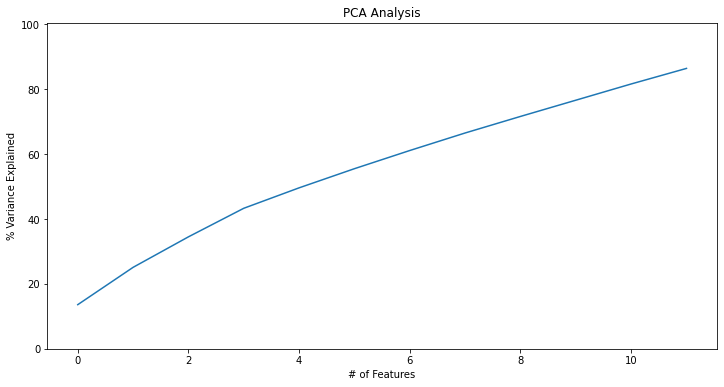

In [67]:
# EXPLAINED VARIANCE FOR 12 FEATURES
pca = PCA(n_components=12)
pca.fit(df_encoded)
variance = pca.explained_variance_ratio_ 
print(variance)
var=np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)

In [68]:
pca = PCA(n_components=3).fit(df_encoded)
pca2 = pca.transform(df_encoded)

pca_df = pd.DataFrame(pca2)
print(pca_df.shape)
pca_df.head()

(3558, 3)


,0,1,2
0,-0.426484,-0.125397,-0.758284
1,0.884347,-0.683676,0.862780
2,0.988778,0.606255,0.294237
3,-0.198352,-0.137649,-0.385939
4,-0.131153,0.688721,-0.312957


#### PCA from Scratch

In [69]:
def PCA_Scratch(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
    
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
    
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
    
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced

#Applying it to PCA function
mat_reduced = PCA_Scratch(df_encoded , 3)
# Creating a Pandas DataFrame of reduced Dataset
pca_df = pd.DataFrame(mat_reduced , columns = [0,1,2])
 
#Concat it with target variable to create a complete Dataset
pca_df = pd.concat([pca_df] , axis = 1)
pca_df.head()

,0,1,2
0,-0.425778,-0.125327,-0.749559
1,0.884877,-0.683597,0.866310
2,0.989045,0.606265,0.296017
3,-0.199061,-0.137561,-0.390522
4,-0.132282,0.688700,-0.322761


C:\Users\ASUS\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

No handles with labels found to put in legend.


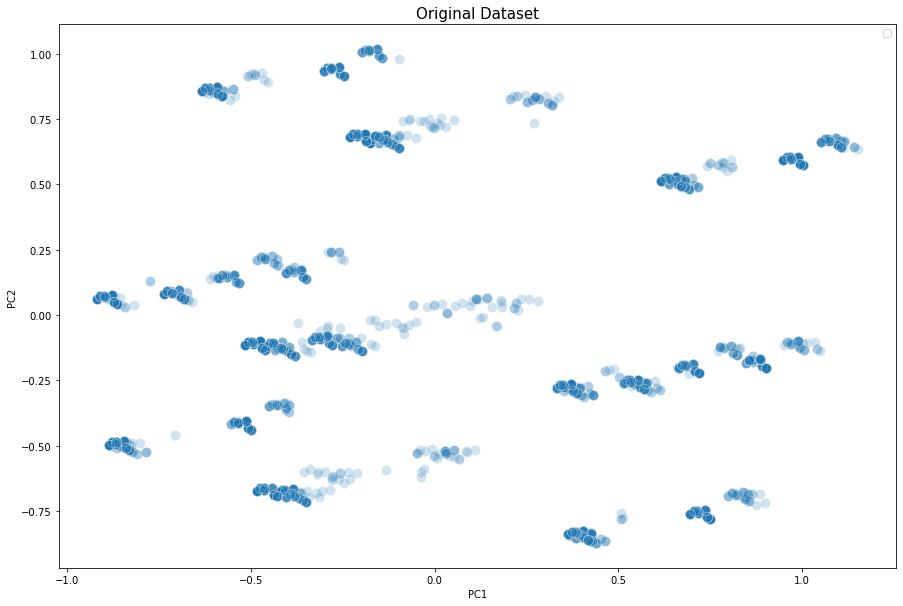

In [70]:
plt.figure(figsize = (15,10))
sns.scatterplot(pca2[:,0], pca2[:,1],
                palette='Set1',
                s=100, alpha=0.2).set_title('Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [71]:
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
trace = go.Scatter3d(x=pca2[:,0], y=pca2[:,1], z=pca2[:,2], mode='markers',marker=dict(color = "black", colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 800,width = 800)

data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

# OUTLIERS TESTING USING Z-SCORE AND IQR

### z-score

In [72]:
from scipy import stats
import numpy as np

test_df = pca_df.copy()
z = np.abs(stats.zscore(test_df))
print(z)

threshold = 3
print(np.where(z > 3))

[[0.69676141 0.22313587 1.47213863]
 [1.44804853 1.21709769 1.70143881]
 [1.6185144  1.07941295 0.58137894]
 ...
 [0.15737316 1.13559543 0.62085132]
 [0.7683704  0.22603829 1.90808899]
 [1.4501351  0.30110064 0.43524163]]
(array([], dtype=int64), array([], dtype=int64))


As we can see, on the result above, we cannot find any values that bigger than threshold 3, so there are no outliers in our dataset for z-score version

### IQR (InterQuartile Range)

In [73]:
Q1 = test_df.quantile(0.25)
Q3 = test_df.quantile(0.75)
IQR = Q3 - Q1

print("IQR for 3D data: ")
print(IQR)

IQR for 3D data: 
0    1.110728
1    1.066298
2    0.749781
dtype: float64


# K-MEANS CLUSTERING

#### 1. SSE from Scratch

In [74]:
def SSE_KMEANS(sse_df, k):
    
    clusters_point = {}
    sse = {}
    
    for index, row in sse_df.iterrows():
        label = row["Label"].astype(int)

        if label not in clusters_point:
            temp_df = sse_df.copy()
            temp_df = temp_df.loc[temp_df["Label"] == label]

            column_0_sum = format(temp_df[0].sum()/temp_df.shape[0], ".6f")
            column_1_sum = format(temp_df[1].sum()/temp_df.shape[0], ".6f")
            column_2_sum = format(temp_df[2].sum()/temp_df.shape[0], ".6f")

            core_point = [column_0_sum, column_1_sum, column_2_sum]
            clusters_point[label] = core_point

        x = row[0]
        y = row[1]
        z = row[2]
        
        corepoint = np.array(clusters_point[label]).astype(float)
        sse_formula = ((x - corepoint[0])**2) + ((y - corepoint[1])**2) + ((z - corepoint[2])**2)

        if label in sse:
            prev_sse = sse[label]
            sse_cluster = prev_sse + sse_formula        
            sse[label] = sse_cluster

        else:
            sse[label] = sse_formula

    values = sse.values()
    
    print(f"SSE K = {k}: ")
    print(f"SSE value for each cluster in {k} clusters: {dict(sorted(sse.items()))}")
    print()
    
    SSE = sum(values)
    return SSE

#### 2. Tuning k value of K-Means for 2 ~ 30

In [75]:
## Clustering with KMeans
start_time = datetime.now().strftime("%H:%M:%S")

sse = []
sse_scratch = []
silhouette = []
km_labels = []

K = list(range(2, 30))

for k in K:
    
    kmeans = KMeans(n_clusters=k).fit(pca_df)
    
    labels = kmeans.labels_
    km_labels.append(labels)
    
    score = metrics.silhouette_score(pca_df, labels)
    silhouette.append(score)
    sse.append(kmeans.inertia_)
    
    sse_df = pca_df.copy()
    sse_df['Label'] = labels
    
    sse_value = SSE_KMEANS(sse_df, k)
    sse_scratch.append(sse_value)

SSE K = 2: 
SSE value for each cluster in 2 clusters: {0: 1366.5498745166244, 1: 863.2947145536785}

SSE K = 3: 
SSE value for each cluster in 3 clusters: {0: 616.8623968214224, 1: 805.8054112696976, 2: 271.9177609626344}

SSE K = 4: 
SSE value for each cluster in 4 clusters: {0: 81.07231309040559, 1: 584.5208180410375, 2: 374.53369118613654, 3: 271.9177609626344}

SSE K = 5: 
SSE value for each cluster in 5 clusters: {0: 242.41341828697085, 1: 81.07231309040559, 2: 344.76563877821565, 3: 213.688164717652, 4: 116.6598682607656}

SSE K = 6: 
SSE value for each cluster in 6 clusters: {0: 29.73808008887834, 1: 241.187787123181, 2: 86.64286536245315, 3: 206.587628417394, 4: 132.7756015063538, 5: 132.331935611946}

SSE K = 7: 
SSE value for each cluster in 7 clusters: {0: 4.914928892744915, 1: 122.30395040833312, 2: 106.05961442948916, 3: 225.09906083859727, 4: 70.5946121156227, 5: 63.38998066951917, 6: 102.30068199214571}

SSE K = 8: 
SSE value for each cluster in 8 clusters: {0: 76.611462

SSE K = 26: 
SSE value for each cluster in 26 clusters: {0: 0.6255973569464849, 1: 4.914928892744915, 2: 0.3133039268199386, 3: 0.16373557328964242, 4: 1.2229978479075625, 5: 0.17768295121331995, 6: 1.3254884216277123, 7: 0.10866105973553615, 8: 0.8267749547190241, 9: 0.21619262259713543, 10: 0.038679213531156956, 11: 1.3370823347972438, 12: 2.622689501988458, 13: 2.4265611253732926, 14: 0.2673057590783704, 15: 1.8276153990159283, 16: 1.51346489280108, 17: 3.351070293483118, 18: 0.31391478182289123, 19: 0.07820122304339801, 20: 0.5561310608844863, 21: 0.4104237820349159, 22: 1.2304211005274348, 23: 0.07899285383891172, 24: 1.288525534414438, 25: 0.09088561920452923}

SSE K = 27: 
SSE value for each cluster in 27 clusters: {0: 0.17768295121331995, 1: 0.16373557328964242, 2: 2.622689501988458, 3: 0.21619262259713543, 4: 0.8267749547190241, 5: 1.2304211005274348, 6: 1.8276153990159283, 7: 1.2496218304451356, 8: 2.108921911408579, 9: 0.6255973569464849, 10: 0.3133039268199386, 11: 1.337082

#### 3. Visualize tuning results

start:  13:48:24
finish:  13:48:48


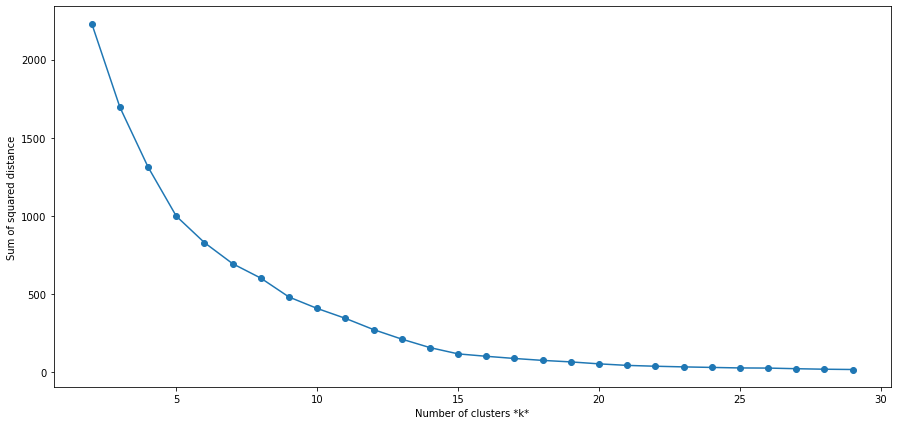

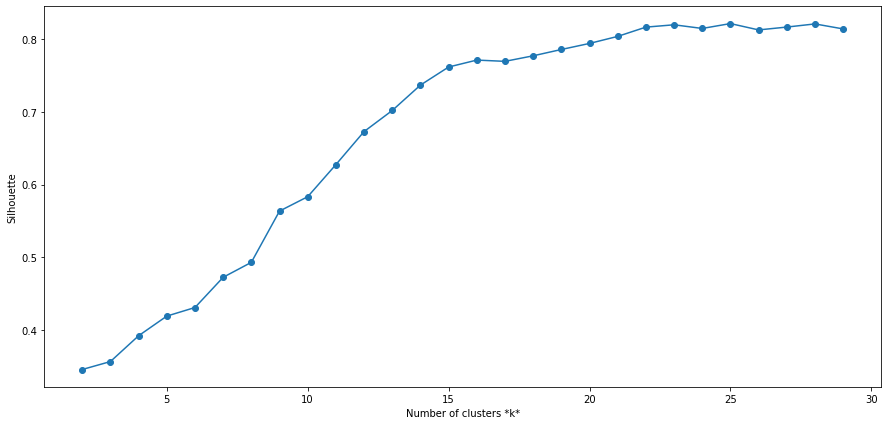

In [76]:
print("start: ", start_time)
print("finish: ", datetime.now().strftime("%H:%M:%S"))

# Plot sse against k
plt.figure(figsize=(15, 7))
plt.plot(K, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

# Plot sse against k
plt.figure(figsize=(15, 7))
plt.plot(K, silhouette, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette');

In [77]:
kmeans_result = list(zip(K, sse, sse_scratch, silhouette))
kmeans_result = pd.DataFrame(kmeans_result, columns=['clusters','SSE', 'SSE_SCRATCH', 'silhouette_score'])

pd.set_option('display.max_rows', kmeans_result.shape[0]+1)
kmeans_result

,clusters,SSE,SSE_SCRATCH,silhouette_score
0,2,2229.845848,2229.844589,0.345336
1,3,1694.585569,1694.585569,0.356287
2,4,1312.045566,1312.044583,0.391816
3,5,998.603031,998.599403,0.418865
4,6,829.263898,829.263898,0.430701
5,7,694.662829,694.662829,0.472302
6,8,602.305044,602.300882,0.492885
7,9,481.574262,481.574262,0.563484
8,10,408.495380,408.495380,0.583256
9,11,345.248334,345.248334,0.627458


#### 4. Using the optimal k value for analysis, where k = 16

In [78]:
# USING LIBRARY
kmeans = KMeans(n_clusters=16).fit(pca_df)
labels = kmeans.labels_
print("Silhouette Score: ", metrics.silhouette_score(pca_df, labels))
print("SSE: ", kmeans.inertia_)

Silhouette Score:  0.7714034772389069
SSE:  102.66763322926113


In [79]:
# KMEANS FROM SCRATCH
class KMeans_scratch:
    
    def __init__(self, X, num_clusters):
        self.K = num_clusters
        self.plot_figure = True
        self.max_iterations = 100
        self.num_examples, self.num_features = X.shape

    def initialize_random_centroids(self,X):
        centroids = np.zeros((self.K, self.num_features))
        for k in range(self.K):
            centroid = X[np.random.choice(range(self.num_examples))]
            centroids[k] = centroid
        
        return centroids
    
    def create_clusters(self, X, centroids):
        clusters = [[] for _ in range(self.K)]
        for point_idx, point in enumerate(X):
            closest_centroid = np.argmin(np.sqrt(np.sum((point-centroids)**2, axis=1)))
            clusters[closest_centroid].append(point_idx) 
        return clusters
            
    def calculate_new_centroids(self, clusters, X):
        centroids = np.zeros((self.K, self.num_features))
        for idx, cluster in enumerate(clusters):
            new_centroid = np.mean(X[cluster], axis=0)
            centroids[idx] = new_centroid
        return centroids
    
    def predict_cluster(self, clusters, X):
        y_pred = np.zeros(self.num_examples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                y_pred[sample_idx] = cluster_idx
        return y_pred
    
    def fit(self, X):
        centroids = self.initialize_random_centroids(X)
        for it in range(self.max_iterations):
            clusters = self.create_clusters(X, centroids)
            prev_centroids = centroids
            centroids = self.calculate_new_centroids(clusters, X)
#             for idx, cluster in enumerate(clusters):
            diff = centroids - prev_centroids
            if not diff.any():
                break
        y_pred = self.predict_cluster(clusters, X)
        return y_pred
    
if __name__ == "__main__":
    np.random.seed(10)
    num_clusters = 16
    
    Kmeans = KMeans_scratch(pca2, num_clusters)
    y_pred = Kmeans.fit(pca2)
    sse_df = pca_df.copy()
    sse_df['Label'] = y_pred
    SSE = SSE_KMEANS(sse_df, num_clusters)
    SC = metrics.silhouette_score(pca_df, y_pred)
    
    print("Silhouette Score: ", SC)
    print("SSE: ", SSE)

SSE K = 16: 
SSE value for each cluster in 16 clusters: {0: 46.70237404475288, 1: 0.049741576992915024, 2: 0.41042842386952283, 3: 0.18092088579759452, 4: 0.6255973569464849, 5: 3.2269450129978026, 6: 1.3370823347972438, 7: 29.73808008887834, 8: 4.914928892744915, 9: 0.09088561920452923, 10: 74.15385676039185, 11: 6.556860433004134, 12: 10.367448265399796, 13: 10.812612710030143, 14: 64.92498041175713, 15: 17.267737967812682}

Silhouette Score:  0.603742269954131
SSE:  271.36048078537794


#### 5. Visualize clustering result

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


C:\Users\ASUS\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



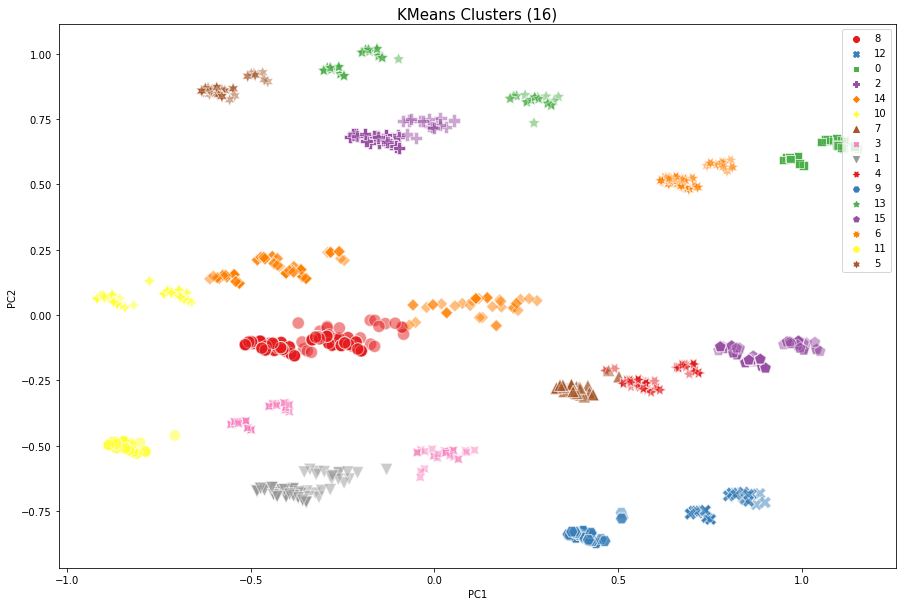

In [80]:
print(np.unique(labels))

pca2 = PCA(n_components=3).fit(pca_df)
pca2d = pca2.transform(pca_df)

plt.figure(figsize = (15,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels.astype(str), 
                style=labels.astype(str),
                palette='Set1',
                s=150, alpha=0.5).set_title('KMeans Clusters (16)', fontsize=15)

plt.legend(loc='upper right',  fontsize='10')
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [81]:
fig = px.scatter_3d(pca_df, x=pca2d[:,0], y=pca2d[:,1], z=pca2d[:,2],
              color=labels.astype(str), size_max=20)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), height = 800,width = 800)

In [82]:
kmeans_df = location_df.copy()
kmeans_df["Cluster"] = labels
kmeans_df.head()

,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle,lat,long,Cluster
0,Thursday,Evening,insinyur sutami,tamalanrea,T,R2,NOV,-5.081195,119.500028,8
1,Sunday,Morning,tol reformasi,tamalanrea,TK,TR,R4,-5.110070,119.443122,12
2,Sunday,Afternoon,perintis kemerdekaan,biringkanaya,TK,R2,R4,-5.075747,119.522922,0
3,Friday,Night,jenderal sudirman,ujung pandang,T,R2,NOV,-5.133096,119.413658,8
4,Sunday,Afternoon,tanjung alang,mamajang,TM,R2,NOV,-5.173570,119.408549,2


In [83]:
for i in np.unique(labels):
    total = len(kmeans_df.loc[kmeans_df["Cluster"]==i])
    day = np.unique(kmeans_df.loc[kmeans_df["Cluster"]==i]["day"].values)
    time = np.unique(kmeans_df.loc[kmeans_df["Cluster"]==i]["time"].values)
    accident_types = np.unique(kmeans_df.loc[kmeans_df["Cluster"]==i]["accident_types"].values)
    vehicles = (list(dict.fromkeys(list(np.unique(kmeans_df.loc[kmeans_df["Cluster"]==i]["victim_vehicle"].values)) + list(np.unique(kmeans_df.loc[kmeans_df["Cluster"]==i]["suspect_vehicle"].values)))))
    vehicles.remove("NOV") if "NOV" in vehicles else vehicles
    
    print("""Total data pada Klaster {} adalah {}:
            days: {}
            time: {}
            accident_types: {} 
            vehicles involved: {}        
        """.format(i, total, day, time, accident_types, vehicles ))

Total data pada Klaster 0 adalah 247:
            days: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
            time: ['Afternoon']
            accident_types: ['TK'] 
            vehicles involved: ['B2', 'M', 'R2', 'R4', 'Rro', 'TR', 'R3']        
        
Total data pada Klaster 1 adalah 281:
            days: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
            time: ['Morning']
            accident_types: ['LL' 'OC' 'T' 'TB' 'TM'] 
            vehicles involved: ['R2', 'R3', 'R4', 'B2', 'M', 'TR']        
        
Total data pada Klaster 2 adalah 292:
            days: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
            time: ['Afternoon']
            accident_types: ['LL' 'OC' 'T' 'TB' 'TM'] 
            vehicles involved: ['R2', 'B2', 'R3', 'TR']        
        
Total data pada Klaster 3 adalah 136:
            days: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesda

# ACCIDENT-PRONE LOCATION IDENTIFICATION 

In [84]:
dups_df = kmeans_df.copy()
dups_df['Count'] = 1
dups_df = dups_df.groupby(['address', 'district', 'lat', 'long', 'Cluster']).Count.count().reset_index()
dups_df.shape

(1821, 6)

In [85]:
dups_df = dups_df.loc[dups_df['Count']>=6]
dups_df.reset_index(drop=True, inplace=True)
dups_df

,address,district,lat,long,Cluster,Count
0,boulevard,panakkukang,-5.157079,119.447818,15,6
1,cendrawasih,mariso,-5.155219,119.413701,8,6
2,cendrawasih,mariso,-5.155219,119.413701,9,8
3,daeng tata raya,tamalate,-5.185002,119.423432,11,6
4,insinyur sutami,biringkanaya,-5.068230,119.524526,0,7
...,...,...,...,...,...,...
75,urip sumuharjo,panakkukang,-5.134824,119.431682,14,13
76,urip sumuharjo,panakkukang,-5.134824,119.431682,15,12
77,veteran utara,makassar,-5.145703,119.424869,1,7
78,veteran utara,makassar,-5.145703,119.424869,8,6


In [86]:
# identified accident-prone location in cluster 0
dups_df.loc[dups_df['Cluster'] == 0]

,address,district,lat,long,Cluster,Count
4,insinyur sutami,biringkanaya,-5.068230,119.524526,0,7
7,insinyur sutami,tamalanrea,-5.081195,119.500028,0,6
15,metro tanjung bunga,tamalate,-5.166158,119.391744,0,9
21,pengayoman,panakkukang,-5.160137,119.448163,0,6
22,perintis kemerdekaan,biringkanaya,-5.075747,119.522922,0,18
36,perintis kemerdekaan,tamalanrea,-5.126885,119.502247,0,15
50,pettarani,panakkukang,-5.136641,119.440041,0,8
58,sultan alauddin,tamalate,-5.168237,119.420982,0,8
61,urip sumuharjo,panakkukang,-5.134824,119.431682,0,10


In [87]:
# identified accident-prone location in cluster 1
dups_df.loc[dups_df['Cluster'] == 1]

,address,district,lat,long,Cluster,Count
5,insinyur sutami,biringkanaya,-5.068230,119.524526,1,8
8,insinyur sutami,tamalanrea,-5.081195,119.500028,1,6
19,pajaiang,biringkanaya,-5.104803,119.525217,1,6
23,perintis kemerdekaan,biringkanaya,-5.075747,119.522922,1,11
37,perintis kemerdekaan,tamalanrea,-5.126885,119.502247,1,33
55,pettarani,rappocini,-5.152195,119.437475,1,6
62,urip sumuharjo,panakkukang,-5.134824,119.431682,1,23
77,veteran utara,makassar,-5.145703,119.424869,1,7
